<a href="https://colab.research.google.com/github/sethoscope/aimsc-redux/blob/master/Train_and_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os
import os.path
MOUNT_POINT='/content/drive'
if not os.path.exists(MOUNT_POINT):
    drive.mount(MOUNT_POINT)
PROJECT_ROOT = os.path.join(MOUNT_POINT, 'My Drive/aimsc-redux')
MUSIC_DIR = os.path.join(PROJECT_ROOT, 'music')
%cd {MUSIC_DIR}
!pip install torchaudio

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/aimsc-redux/music
     |████████████████████████████████| 3.2MB 2.7MB/s 


In [2]:
import logging
from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter, FileType

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import torchaudio
import pandas as pd
import numpy as np
import yaml
import time
import os


# assumptions:
#   all inputs have the same sampling frequency
#   all songs are long enough for the segment size we want
class AudioDataset(Dataset):
    def __init__(self, songs, music_dir, segment_length, segments_per_song, downsample_rate):
        self.songs = songs
        self.music_dir = music_dir
        self.segments_per_song = segments_per_song
        self.segment_length = segment_length # audio samples per datum
        self.downsample_rate = downsample_rate

        labels = sorted(list(set(s.label for s in songs)))   # all the labels
        self.label_number_map = {v:i for i,v in enumerate(labels)}   # {'foo':0, 'bar':1, ...}

    def __getitem__(self, i):
        song_index = int(i / self.segments_per_song)
        segment_index = i % self.segments_per_song
        song = self.songs[song_index]
        audio = song.audio(segment_index, self.music_dir, self.segment_length,
                           self.segments_per_song, self.downsample_rate)
        
        return audio, self.label_number_map[song.label]

    def __len__(self):
        return len(self.songs * self.segments_per_song)

class Song():
    def __init__(self, fields):
        self.fields = fields
        self.__dict__.update(fields)

    def __repr__(self):
        return 'Song<{}>'.format(str(list(self.fields.values())))

    def audio(self, segment_index, music_dir, segment_length, segments_per_song, downsample_rate):
        (audio, samplingfreq) = torchaudio.load(os.path.join(music_dir, self.filename))
        audio = audio.permute(1, 0) # 1×N ~ N×1
        # downsample, and keep the amount amount of data specified
        if audio.size()[0] / downsample_rate < segments_per_song * segment_length:
            logging.error(f'song too short! length: {audio.size()[0]}, need {segments_per_song * segment_length * downsample_rate}')
        return audio[segment_index * segment_length * downsample_rate
                     : (segment_index+1) * segment_length * downsample_rate
                     : downsample_rate].permute(1, 0)

class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(1, 128, 80, 4)
        self.bn1 = nn.BatchNorm1d(128)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(128, 128, 3)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(128, 256, 3)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(256, 512, 3)
        self.bn4 = nn.BatchNorm1d(512)
        self.pool4 = nn.MaxPool1d(4)
        self.avgPool = nn.AvgPool1d(30) #input should be 512x30 so this outputs a 512x1
        self.fc1 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = self.avgPool(x)
        x = x.permute(0, 2, 1) #change the 512x1 to 1x512
        x = self.fc1(x)
        return F.log_softmax(x, dim = 2)


class Thing():
    def __init__(self, log_interval):
        self.log_interval = log_interval
        self.test_results = []

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        logging.debug(f'Device: {self.device}')
        if torch.cuda.is_available():
            logging.debug(f'we have {torch.cuda.device_count()} GPU(s)')


    def train(self, epoch):
        self.model.train()
        for batch_idx, (data, target) in enumerate(self.train_loader):
            self.optimizer.zero_grad()
            data = data.to(self.device)
            target = target.to(self.device)
            data = data.requires_grad_() #set requires_grad to True for training
            output = self.model(data)
            output = output.permute(1, 0, 2) #original output dimensions are batchSizex1x10 
            loss = F.nll_loss(output[0], target) #the loss functions expects a batchSizex10 input
            loss.backward()
            self.optimizer.step()
            if batch_idx % self.log_interval == 0: #print training stats
                logging.info('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(self.train_loader.dataset),
                    100. * batch_idx / len(self.train_loader), loss))


    def test(self, epoch):
        self.model.eval()
        correct = 0
        for data, target in self.test_loader:
            data = data.to(self.device)
            target = target.to(self.device)
            output = self.model(data)
            output = output.permute(1, 0, 2)
            pred = output.max(2)[1] # get the index of the max log-probability
            correct += pred.eq(target).cpu().sum().item()
        print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(
            correct, len(self.test_loader.dataset),
            100. * correct / len(self.test_loader.dataset)))
        return correct / len(self.test_loader.dataset)


    def go(self, epochs):
        start_time = time.time()
        for epoch in range(1, epochs + 1):
            epoch_start_time = time.time()
            self.train(epoch)
            self.test_results.append(self.test(epoch))
            self.scheduler.step()
            logging.info('Epoch {}, epoch time: {}, total time: {} seconds'.format(epoch,
                                                                                   int(time.time() - epoch_start_time),
                                                                                   int(time.time() - start_time)))

In [ ]:
epochs=40
segment_length=32000
segments_per_song=4
downsample_rate=5
music_dir=os.path.join(MUSIC_DIR, '20sec')
metadata=open(os.path.join(PROJECT_ROOT, '2-classes-wav.yaml'),'r')
logging.getLogger().setLevel(logging.INFO)
#logging.getLogger().setLevel(logging.DEBUG)

songs = [Song(s) for s in yaml.safe_load(metadata)]

thing = Thing(log_interval = 20)
thing.train_set = AudioDataset([s for s in songs if s.role == 'train'],
                                music_dir, segment_length,
                                segments_per_song, downsample_rate)
thing.test_set = AudioDataset([s for s in songs if s.role == 'test'],
                                music_dir, segment_length,
                                segments_per_song, downsample_rate)
logging.info(f'Train set size: {len(thing.train_set)}')
logging.info(f'Test set size: {len(thing.test_set)}')

kwargs = {'num_workers': 1, 'pin_memory': True} if thing.device == 'cuda' else {}
thing.train_loader = torch.utils.data.DataLoader(thing.train_set, batch_size = 128, shuffle = True, **kwargs)
thing.test_loader = torch.utils.data.DataLoader(thing.test_set, batch_size = 128, shuffle = True, **kwargs)

thing.model = Net(2)
thing.model.to(thing.device)
    
thing.optimizer = optim.Adam(thing.model.parameters(), lr = 0.01, weight_decay = 0.0001)
thing.scheduler = optim.lr_scheduler.StepLR(thing.optimizer, step_size = int(epochs/2), gamma = 0.1)

thing.go(epochs)
print('Done')
thing.test_results

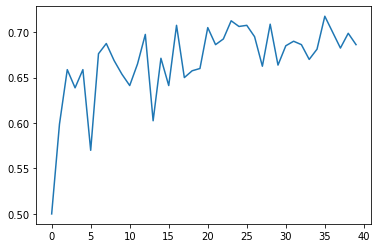

In [8]:
import matplotlib.pyplot as plt
plt.plot(thing.test_results)
plt.show()